In [89]:
import pandas as pd
import numpy as np

In [30]:
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

In [80]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

In [31]:
%matplotlib inline

In [4]:
!dir data

 Volume in drive C is Windows
 Volume Serial Number is 3EE2-6AB7

 Directory of C:\Users\17001970\Documents\Goman\future_sales\data

23/10/2018  18:31    <DIR>          .
23/10/2018  18:31    <DIR>          ..
26/06/2018  07:37         1,568,417 items.csv
26/06/2018  07:37             3,573 item_categories.csv
26/06/2018  07:37        13,515,545 sales_train.csv.gz
26/06/2018  07:37           480,004 sample_submission.csv.gz
26/06/2018  07:37             2,977 shops.csv
26/06/2018  07:37         1,058,887 test.csv.gz
               6 File(s)     16,629,403 bytes
               2 Dir(s)  826,479,714,304 bytes free


In [5]:
items = pd.read_csv('data/items.csv')

In [6]:
items.columns

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')

In [7]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
item_categories = pd.read_csv('data/item_categories.csv')

In [9]:
item_categories.columns

Index(['item_category_name', 'item_category_id'], dtype='object')

In [10]:
item_categories.head(5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
sales = pd.read_csv('data/sales_train.csv.gz')

In [12]:
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [17]:
sales.shape

(2935849, 6)

In [19]:
import datetime

In [20]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [21]:
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [14]:
shops = pd.read_csv('data/shops.csv')

In [22]:
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [15]:
shops.columns

Index(['shop_name', 'shop_id'], dtype='object')

In [16]:
shops.head(5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


# data explore

## Sales

In [25]:
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [23]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [24]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [26]:
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [28]:
monthly_sales.head(20)

item_price item_cnt_day       date           
                                     mean          sum        min        max
date_block_num shop_id item_id                                              
0              0       32           221.0          6.0 2013-01-03 2013-01-31
                       33           347.0          3.0 2013-01-03 2013-01-28
                       35           247.0          1.0 2013-01-31 2013-01-31
                       43           221.0          1.0 2013-01-31 2013-01-31
                       51           128.5          2.0 2013-01-13 2013-01-31
                       61           195.0          1.0 2013-01-10 2013-01-10
                       75            76.0          1.0 2013-01-17 2013-01-17
                       88            76.0          1.0 2013-01-16 2013-01-16
                       95           193.0          1.0 2013-01-06 2013-01-06
                       96            70.0          1.0 2013-01-10 2013-01-10
                       98           268.0         25.0 2013-01-04 2013-01-31
                       111           89.0          1.0 2013-01-17 2013-01-17
                       149           99.0          3.0 2013-01-11 2013-01-28
                       151           75.0          1.0 2013-01-16 2013-01-16
                       153          258.0          1.0 2013-01-09 2013-01-09
                       198          112.0          1.0 2013-01-10 2013-01-10
                       210          118.0          2.0 2013-01-05 2013-01-25
                       282          109.0          1.0 2013-01-04 2013-01-04
                       306           59.0          1.0 2013-01-22 2013-01-22
                       351           89.0          1.0 2013-01-21 2013-01-21

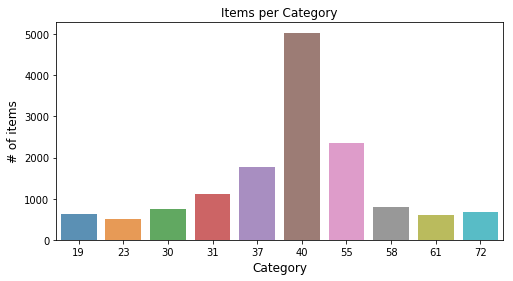

In [41]:
# number of items per cat 
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [42]:
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


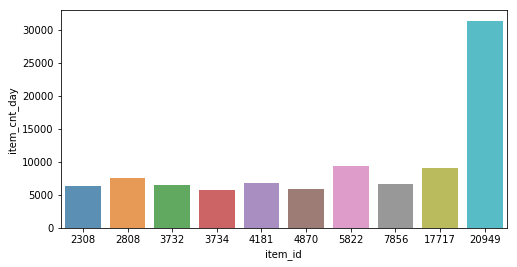

In [48]:
x=sales.groupby(['item_id']).count()
x=x.sort_values(by='item_cnt_day',ascending=False)
x=x.iloc[0:10].reset_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_id, x.item_cnt_day, alpha=0.8)


Let's assume that the 20949 product 

C:\Users\17001970\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


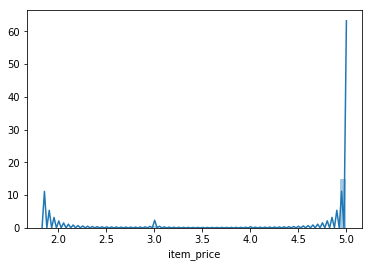

In [53]:
sns.distplot(sales[sales.item_id==20949]['item_price'],);

So the price of the most bought product is not affected to # of buy

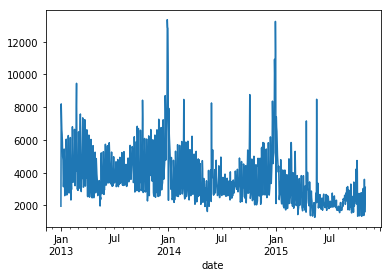

In [55]:
sales.groupby(['date'])['item_cnt_day'].sum().plot()

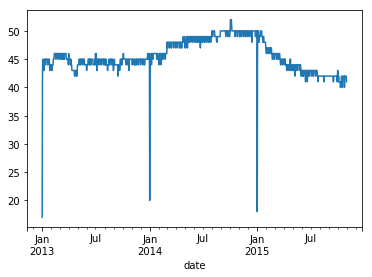

In [71]:
sales.groupby(['date',])['shop_id'].nunique().plot()

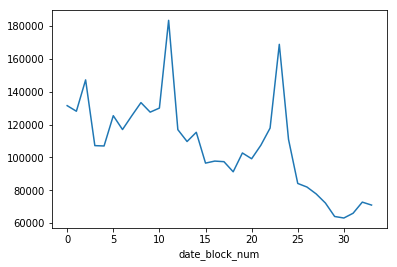

In [73]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.plot()

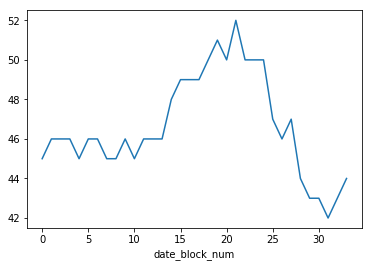

In [72]:
sales.groupby(['date_block_num',])['shop_id'].nunique().plot()

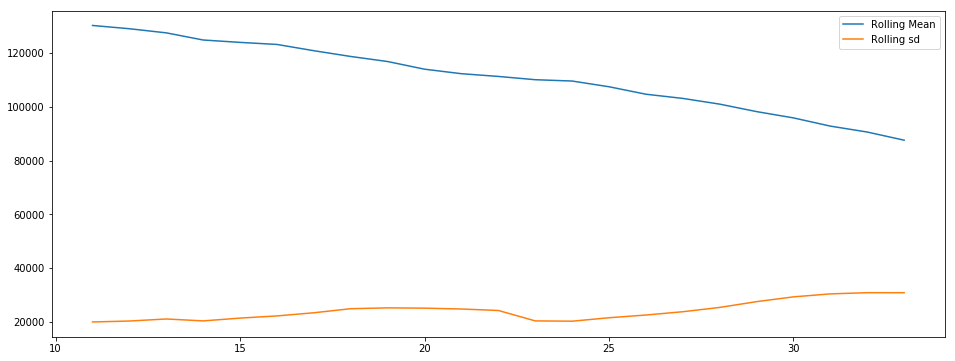

In [74]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();


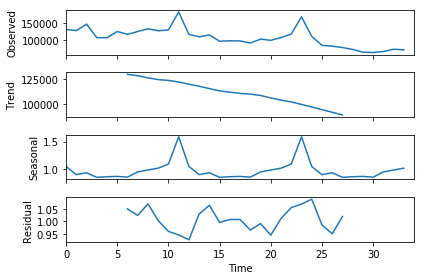

In [75]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()

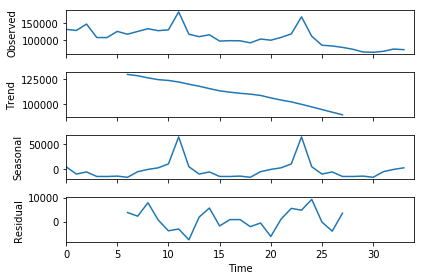

In [79]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
# plt.figure(figsize=(16,12))
fig = res.plot()
# fig.show()

## See how previous month affect sales

In [114]:
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [131]:
max_num = sales['date_block_num'].max()
last_sales=  sales[sales['date_block_num'] == max_num]
curr = max_num

for i in range(1,2):
    previous_sales = sales.copy()
    previous_sales = previous_sales[['date_block_num', 'shop_id', 'item_id', 'item_price']]
    previous_sales = previous_sales[previous_sales['date_block_num'] == curr - 1]
    previous_sales['block_%s_lag_%s_item_price' % (curr-1, i)] = previous_sales['item_price']
    previous_sales['block_%s_lag_%s_item_cnt_day' % (curr-1, i)] = previous_sales['item_price']
    last_sales = pd.merge(last_sales, previous_sales, on=['shop_id', 'item_id'], how='left')
    curr = curr - 1
    print(curr)

32


In [135]:
a = sales[sales['date_block_num'] == max_num]
b = sales[sales['date_block_num'] == max_num-1]

In [136]:
a.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [183]:
a = a[[ 'shop_id', 'item_id', 'item_price','item_cnt_day']]
b = b[[ 'shop_id', 'item_id', 'item_price','item_cnt_day']]

c= pd.merge(a,b,on=['shop_id', 'item_id'], how='left')
c.shape

(134671, 6)

In [201]:
c['asd'] = c.shop_id.astype('str') + '_' + c.item_id.astype('str')

In [206]:
a['asd'] = a.shop_id.astype('str') + '_' + a.item_id.astype('str')

In [207]:
b['asd'] = b.shop_id.astype('str') + '_' + b.item_id.astype('str')

In [212]:
a.shape

(53514, 5)

In [224]:
a1= a.groupby('asd')['asd','shop_id'].count()

In [225]:
c1 = c.groupby('asd')['asd','shop_id'].count()

In [226]:
b1 = b.groupby('asd')['asd','shop_id'].count()

In [ ]:
c2 = pd.merge(a1,b1)

In [214]:
c[c.asd.isin(b.asd) == True].shape

(106639, 7)

In [147]:
b[[ 'shop_id', 'item_id', 'item_price',
       'item_cnt_day']].head(5)

,shop_id,item_id,item_price,item_cnt_day
2831747,42,11170,58.0,1.0
2831748,42,11215,349.0,1.0
2831749,42,11215,349.0,1.0
2831750,42,11215,349.0,1.0
2831751,42,11232,299.0,1.0


In [148]:
a[[ 'shop_id', 'item_id', 'item_price',
       'item_cnt_day']].head(5)

,shop_id,item_id,item_price,item_cnt_day
2882335,45,13315,649.0,1.0
2882336,45,13880,229.0,1.0
2882337,45,13881,659.0,1.0
2882338,45,13881,659.0,1.0
2882339,45,13923,169.0,1.0


In [143]:
c.shape

(134671, 6)

In [138]:
c.shape

(106639, 6)

In [132]:
last_sales.shape

(134671, 10)

In [118]:
last_sales.head(5)

,date,date_block_num_x,shop_id,item_id,item_price_x,item_cnt_day,date_block_num_y,item_price_y,block_32_lag_1_item_price,block_32_lag_1_item_cnt_day,date_block_num,item_price,block_31_lag_2_item_price,block_31_lag_2_item_cnt_day
0,2015-10-23,33,45,13315,649.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-10-05,33,45,13880,229.0,1.0,NaN,NaN,NaN,NaN,31.0,229.0,229.0,229.0
2,2015-10-05,33,45,13880,229.0,1.0,NaN,NaN,NaN,NaN,31.0,229.0,229.0,229.0
3,2015-10-02,33,45,13881,659.0,1.0,32.0,659.0,659.0,659.0,31.0,599.0,599.0,599.0
4,2015-10-12,33,45,13881,659.0,1.0,32.0,659.0,659.0,659.0,31.0,599.0,599.0,599.0


In [105]:
before_sales = sales[sales['date_block_num'] < max_num]

In [106]:
before_sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


# Test

In [90]:
test = pd.read_csv('data/test.csv.gz')

In [94]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


# Submission

In [92]:
sample_submission = pd.read_csv('data/sample_submission.csv.gz')

In [93]:
sample_submission

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
5,5,0.5
6,6,0.5
7,7,0.5
8,8,0.5
9,9,0.5
